# DataJoint Workflow Array Ephys

This notebook will describe the steps for interacting with the data ingested into `workflow-array-ephys`.

In [2]:
import os
os.chdir('..')

In [2]:
import datajoint as dj
import matplotlib.pyplot as plt
import numpy as np

from workflow_array_ephys.pipeline import lab, subject, session, ephys

Connecting root@localhost:3306


## Workflow architecture

This workflow is assembled from 4 DataJoint elements:
+ [element-lab](https://github.com/datajoint/element-lab)
+ [element-animal](https://github.com/datajoint/element-animal)
+ [element-session](https://github.com/datajoint/element-session)
+ [element-array-ephys](https://github.com/datajoint/element-array-ephys)

For the architecture and detailed descriptions for each of those elements, please visit the respective links. 

Below is the diagram describing the core components of the fully assembled pipeline.


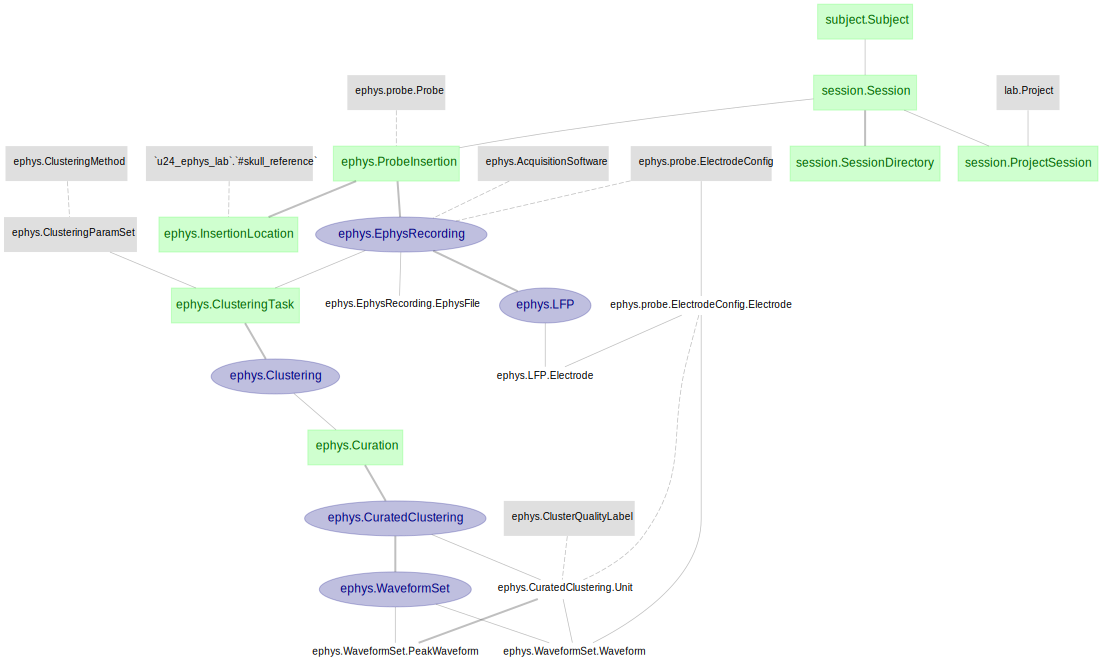

In [3]:
dj.Diagram(ephys) + (dj.Diagram(session.Session) + 1) - 1

## Browsing the data with DataJoint query and fetch 


DataJoint provides abundant functions to query data and fetch. For a detailed tutorials, visit our [general tutorial site](https://playground.datajoint.io/)


Running through the pipeline, we have ingested data of subject6 session1 into the database. Here are some highlights of the important tables.

### `Subject` and `Session` tables

In [4]:
subject.Subject()

subject,sex,subject_birth_date,subject_description
subject6,M,2020-01-04,


In [5]:
session.Session()

subject,session_datetime
subject6,2021-01-15 11:16:38


In [6]:
session_key = (session.Session & 'subject="subject6"' & 'session_datetime = "2021-01-15 11:16:38"').fetch1('KEY')

### `ephys.ProbeInsertion` and `ephys.EphysRecording` tables

These tables stores the probe recordings within a particular session from one or more probes.

In [7]:
ephys.ProbeInsertion & session_key

subject,session_datetime,insertion_number,probe unique identifier for this model of probe (e.g. serial number)
subject6,2021-01-15 11:16:38,0,17131311651


In [8]:
ephys.EphysRecording & session_key

subject,session_datetime,insertion_number,electrode_config_hash,acq_software,sampling_rate (Hz)
subject6,2021-01-15 11:16:38,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,SpikeGLX,30000.6


### `ephys.ClusteringTask` , `ephys.Clustering`, `ephys.Curation`, and `ephys.CuratedClustering`

+ Spike-sorting is performed on a per-probe basis with the details stored in `ClusteringTask` and `Clustering`

+ After the spike sorting, the results may go through curation process. 
    + If it did not go through curation, a copy of `ClusteringTask` entry was inserted into table `ephys.Curation` with the `curation_ouput_dir` identicial to the `clustering_output_dir`. 
    + If it did go through a curation, a new entry will be inserted into `ephys.Curation`, with a `curation_output_dir` specified.
    + `ephys.Curation` supports multiple curations of a clustering task.

In [9]:
ephys.ClusteringTask * ephys.Clustering & session_key

subject,session_datetime,insertion_number,paramset_idx,clustering_output_dir clustering output directory relative to the clustering root data directory,"task_mode 'load': load computed analysis results, 'trigger': trigger computation",clustering_time time of generation of this set of clustering results,package_version
subject6,2021-01-15 11:16:38,0,0,subject6/session1/towersTask_g0_imec0,load,2021-02-22 23:07:16,


In our example workflow, `curation_output_dir` is the same as `clustering_output_dir`

In [10]:
ephys.Curation * ephys.CuratedClustering & session_key

subject,session_datetime,insertion_number,paramset_idx,curation_id,curation_time time of generation of this set of curated clustering results,"curation_output_dir output directory of the curated results, relative to clustering root data directory",quality_control has this clustering result undergone quality control?,manual_curation has manual curation been performed on this clustering result?,curation_note
subject6,2021-01-15 11:16:38,0,0,1,2021-04-28 15:47:01,subject6/session1/towersTask_g0_imec0,0,0,
subject6,2021-01-15 11:16:38,0,0,2,2021-02-22 23:07:16,subject6/session1/towersTask_g0_imec0,0,0,


### Spike-sorting results are stored in `ephys.CuratedClustering`,  `ephys.WaveformSet.Waveform`

In [11]:
ephys.CuratedClustering.Unit & session_key

subject,session_datetime,insertion_number,paramset_idx,curation_id,unit,electrode_config_hash,probe_type e.g. neuropixels_1.0,"electrode electrode index, starts at 0",cluster_quality_label,spike_count how many spikes in this recording for this unit,"spike_times (s) spike times of this unit, relative to the start of the EphysRecording",spike_sites array of electrode associated with each spike,"spike_depths (um) array of depths associated with each spike, relative to the (0, 0) of the probe"
subject6,2021-01-15 11:16:38,0,0,1,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,0,mua,1227,=BLOB=,=BLOB=,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,1,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,0,mua,9390,=BLOB=,=BLOB=,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,2,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,2,mua,34,=BLOB=,=BLOB=,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,3,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,4,mua,4393,=BLOB=,=BLOB=,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,4,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,5,mua,5535,=BLOB=,=BLOB=,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,5,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,6,mua,20133,=BLOB=,=BLOB=,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,6,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,6,good,8519,=BLOB=,=BLOB=,=BLOB=


Let's pick one probe insertion and one `curation_id`, and further inspect the clustering results.

In [12]:
curation_key = (ephys.CuratedClustering & session_key & 'insertion_number = 0' & 'curation_id=1').fetch1('KEY')

In [13]:
ephys.CuratedClustering.Unit & curation_key

subject,session_datetime,insertion_number,paramset_idx,curation_id,unit,electrode_config_hash,probe_type e.g. neuropixels_1.0,"electrode electrode index, starts at 0",cluster_quality_label,spike_count how many spikes in this recording for this unit,"spike_times (s) spike times of this unit, relative to the start of the EphysRecording",spike_sites array of electrode associated with each spike,"spike_depths (um) array of depths associated with each spike, relative to the (0, 0) of the probe"
subject6,2021-01-15 11:16:38,0,0,1,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,0,mua,1227,=BLOB=,=BLOB=,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,1,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,0,mua,9390,=BLOB=,=BLOB=,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,2,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,2,mua,34,=BLOB=,=BLOB=,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,3,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,4,mua,4393,=BLOB=,=BLOB=,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,4,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,5,mua,5535,=BLOB=,=BLOB=,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,5,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,6,mua,20133,=BLOB=,=BLOB=,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,6,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,6,good,8519,=BLOB=,=BLOB=,=BLOB=


### Generate a raster plot

Let's try a raster plot - just the "good" units

In [14]:
ephys.CuratedClustering.Unit & curation_key & 'cluster_quality_label = "good"'

subject,session_datetime,insertion_number,paramset_idx,curation_id,unit,electrode_config_hash,probe_type e.g. neuropixels_1.0,"electrode electrode index, starts at 0",cluster_quality_label,spike_count how many spikes in this recording for this unit,"spike_times (s) spike times of this unit, relative to the start of the EphysRecording",spike_sites array of electrode associated with each spike,"spike_depths (um) array of depths associated with each spike, relative to the (0, 0) of the probe"
subject6,2021-01-15 11:16:38,0,0,1,6,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,6,good,8519,=BLOB=,=BLOB=,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,7,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,8,good,10475,=BLOB=,=BLOB=,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,9,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,11,good,30,=BLOB=,=BLOB=,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,14,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,14,good,9706,=BLOB=,=BLOB=,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,15,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,14,good,16094,=BLOB=,=BLOB=,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,17,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,14,good,13,=BLOB=,=BLOB=,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,19,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,18,good,16164,=BLOB=,=BLOB=,=BLOB=


In [15]:
units, unit_spiketimes = (ephys.CuratedClustering.Unit 
                          & curation_key 
                          & 'cluster_quality_label = "good"').fetch('unit', 'spike_times')

In [16]:
x = np.hstack(unit_spiketimes)
y = np.hstack([np.full_like(s, u) for u, s in zip(units, unit_spiketimes)])

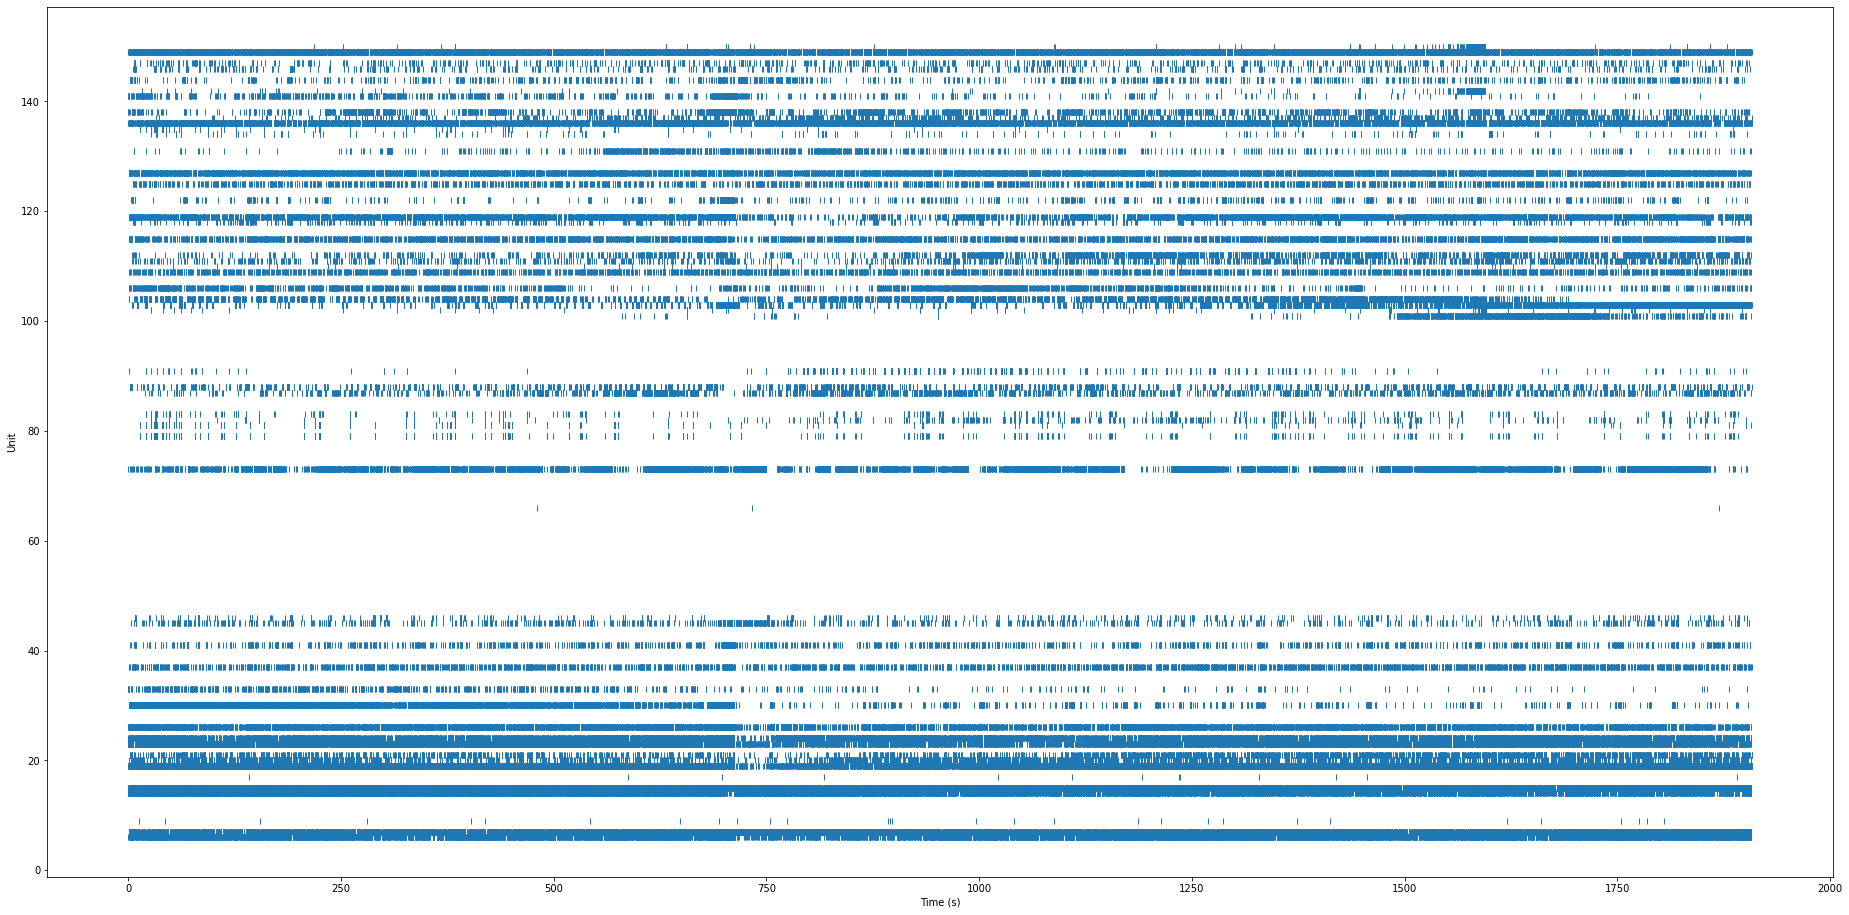

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(32, 16))
ax.plot(x, y, '|')
ax.set_xlabel('Time (s)');
ax.set_ylabel('Unit');

### Plot waveform of a unit

Let's pick one unit and further inspect

In [18]:
unit_key = (ephys.CuratedClustering.Unit & curation_key & 'unit = 15').fetch1('KEY')

In [19]:
ephys.CuratedClustering.Unit * ephys.WaveformSet.Waveform & unit_key

subject,session_datetime,insertion_number,paramset_idx,curation_id,unit,electrode_config_hash,probe_type e.g. neuropixels_1.0,"electrode electrode index, starts at 0",cluster_quality_label,spike_count how many spikes in this recording for this unit,"spike_times (s) spike times of this unit, relative to the start of the EphysRecording",spike_sites array of electrode associated with each spike,"spike_depths (um) array of depths associated with each spike, relative to the (0, 0) of the probe",waveform_mean (uV) mean waveform across spikes of the given unit,waveforms (uV) (spike x sample) waveforms of a sampling of spikes at the given electrode for the given unit
subject6,2021-01-15 11:16:38,0,0,1,15,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,14,good,16094,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=


In [20]:
unit_data = (ephys.CuratedClustering.Unit * ephys.WaveformSet.PeakWaveform & unit_key).fetch1()

In [21]:
unit_data

{'subject': 'subject6',
 'session_datetime': datetime.datetime(2021, 1, 15, 11, 16, 38),
 'insertion_number': 0,
 'paramset_idx': 0,
 'curation_id': 1,
 'unit': 15,
 'electrode_config_hash': UUID('6f6d8149-1603-9d2c-f884-0fdf995ec8b3'),
 'probe_type': 'neuropixels 1.0 - 3B',
 'electrode': 14,
 'cluster_quality_label': 'good',
 'spike_count': 16094,
 'spike_times': array([6.07000000e-02, 9.44666667e-02, 1.99133333e-01, ...,
        1.90760683e+03, 1.90765233e+03, 1.90774290e+03]),
 'spike_sites': array([14, 14, 14, ..., 14, 14, 14]),
 'spike_depths': array([160.47843593, 167.44142806, 169.35855343, ..., 166.23517905,
        166.6919545 , 166.85568899]),
 'peak_electrode_waveform': array([104.2078125, 104.55     , 104.7234375, 103.7296875, 103.4578125,
        104.1328125, 104.3296875, 104.3484375, 104.86875  , 104.60625  ,
        104.5359375, 104.878125 , 104.7328125, 104.79375  , 105.2296875,
        105.2578125, 104.971875 , 104.7796875, 104.971875 , 104.64375  ,
        104.0203125

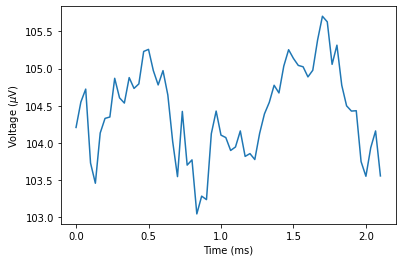

In [22]:
sampling_rate = (ephys.EphysRecording & curation_key).fetch1('sampling_rate')/1000 # in kHz
plt.plot(np.r_[:unit_data['peak_electrode_waveform'].size] * 1/sampling_rate, unit_data['peak_electrode_waveform'])
plt.xlabel('Time (ms)');
plt.ylabel(r'Voltage ($\mu$V)');

## Summary and Next Step

This notebook highlights the major tables in the workflow and visualize some of the ingested results. 

The next notebook [06-drop](06-drop-optional.ipynb) shows how to drop schemas and tables if needed.